来源：https://wiseodd.github.io/techblog/2017/12/23/annealed-importance-sampling/

### 重要性采样简介

$E_{x\sim p(x)}[f(x)]=\int p(x)f(x)dx = \int q(x)\frac{p(x)}{q(x)}f(x)dx=E_{x\sim q(x)}[\frac{p(x)}{q(x)}f(x)]=\frac{1}{N}\sum_{i=1,x_i\sim q(x)}^N \frac{p(x_i)}{q(x_i)}f(x_i)$

代码实现如下：

### AIS简介

假设由这样的分布：

$p(x)=\frac{1}{Z}f(x)$，$Z=\sum_{x} f(x)$

当维度很高时，求$Z$的这种求和操作时不可行的，因为可能有指数个项相加。

$E_{p(x)}[x]=\sum_{x}xp(x)$

若不知道$p(x)$，自然无法计算该期望。此时一种可取的方法是使用重要性采样，用另一个分布$q(x)$来近似$p(x)$。但确定合适的$q(x)$是比较困难的，这就是退火重要性采样（Annealed Importance Sampling，AIS）背后的动机。

### AIS的大致过程

### 代码实现

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


def f_0(x):
    """ Target distribution -- 正比于 N(-5, 2) """
    return np.exp(-(x+5)**2/2/2)

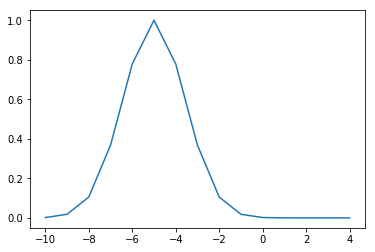

In [5]:
x = np.array(range(-10,5,1))

plt.plot(x, f_0(x))